In [1]:
import matplotlib.pyplot as plt
import numpy as np
import modin.pandas as pd
import dask.dataframe as dd
from dask.utils import tmpfile
from scipy import stats
import statsmodels.api as sm
import pingouin as pg
import seaborn as sns

from dask.distributed import Client
client = Client()  # set up local cluster on your laptop

In [2]:
pd.options.display.max_rows= 1500 #This code allows us to see the full rows
pd.options.display.max_columns= 1500 #This code allows us to see the full columns

In [3]:
#eod_2019.csv is a 200GB file. Just using pandas won't allow to load data frame into memory.
#Dask Dataframe would allow to review the dataframe and prossess while using available RAM and prossesor cores efficiently. 

eBird = dd.read_csv(r'D:\Downloads\2019-eBird-dwca-1.0\BigCSV\eod_2019.csv')

In [4]:
eBird.head()

,basisofrecord,institutioncode,collectioncode,catalognumber,occurrenceid,recordedby,year,month,day,publishingcountry,country,stateprovince,county,decimallatitude,decimallongitude,locality,kingdom,phylum,class,order,family,genus,specificepithet,scientificname,vernacularname,taxonremarks,individualcount
0,HumanObservation,CLO,EBIRD,OBS66902838,URN:catalog:CLO:EBIRD:OBS66902838,obsr178425,1965,1,6,US,United States,New York,Erie,42.6793,-78.9777,Derby,Animalia,Chordata,Aves,Passeriformes,Passerellidae,Spizelloides,arborea,Spizelloides arborea,American Tree Sparrow,NaN,NaN
1,HumanObservation,CLO,EBIRD,OBS66902839,URN:catalog:CLO:EBIRD:OBS66902839,obsr178425,1965,1,6,US,United States,New York,Erie,42.6793,-78.9777,Derby,Animalia,Chordata,Aves,Passeriformes,Sturnidae,Sturnus,vulgaris,Sturnus vulgaris,European Starling,NaN,NaN
2,HumanObservation,CLO,EBIRD,OBS66902840,URN:catalog:CLO:EBIRD:OBS66902840,obsr178425,1965,1,6,US,United States,New York,Erie,42.6793,-78.9777,Derby,Animalia,Chordata,Aves,Passeriformes,Passerellidae,Junco,hyemalis,Junco hyemalis,Dark-eyed Junco,NaN,NaN
3,HumanObservation,CLO,EBIRD,OBS33883196,URN:catalog:CLO:EBIRD:OBS33883196,obsr23008,1988,9,14,CA,Canada,British Columbia,Metro Vancouver,49.1000,-123.1850,Reifel Bird Sanctuary (Temporarily Closed),Animalia,Chordata,Aves,Gruiformes,Rallidae,Rallus,limicola,Rallus limicola,Virginia Rail,NaN,2.0
4,HumanObservation,CLO,EBIRD,OBS33883197,URN:catalog:CLO:EBIRD:OBS33883197,obsr23008,1988,9,14,CA,Canada,British Columbia,Metro Vancouver,49.1000,-123.1850,Reifel Bird Sanctuary (Temporarily Closed),Animalia,Chordata,Aves,Charadriiformes,Scolopacidae,Tringa,melanoleuca,Tringa melanoleuca,Greater Yellowlegs,NaN,40.0


In [5]:
eBird_df = eBird[['catalognumber', 'occurrenceid', 'year', 'month', 'day', 'country', 'stateprovince', 'county','decimallatitude', 'decimallongitude', 'scientificname', 'vernacularname', 'individualcount'  ]]

In [6]:
eBird_dd1 =  eBird_df[eBird_df['country'] == 'United States']

In [7]:
eBird_dd2 = eBird_dd1[['catalognumber', 'occurrenceid', 'year','stateprovince', 'county', 'scientificname', 'vernacularname']]

In [8]:
eBird_dd2.head()

,catalognumber,occurrenceid,year,stateprovince,county,scientificname,vernacularname
0,OBS66902838,URN:catalog:CLO:EBIRD:OBS66902838,1965,New York,Erie,Spizelloides arborea,American Tree Sparrow
1,OBS66902839,URN:catalog:CLO:EBIRD:OBS66902839,1965,New York,Erie,Sturnus vulgaris,European Starling
2,OBS66902840,URN:catalog:CLO:EBIRD:OBS66902840,1965,New York,Erie,Junco hyemalis,Dark-eyed Junco
6,OBS34341037,URN:catalog:CLO:EBIRD:OBS34341037,1998,California,San Mateo,Elanus leucurus,White-tailed Kite
7,OBS34341038,URN:catalog:CLO:EBIRD:OBS34341038,1998,California,San Mateo,Melanerpes formicivorus,Acorn Woodpecker


In [9]:
%%time
US_ST_Cnt_spcs = eBird_dd2.groupby(['year', 'stateprovince']).scientificname.nunique().compute()


Wall time: 40min 55s


On the previous code we sorted and agragated information before having to load the whote csv. Once we had an idea of how to manage the data we proceded to compute and load into memory only the data of interest. Now we can proceed with our analysis with a pandas dataframe but using the modin library to keep the enhance of parralell computing.

In [10]:
US_ST_Cnt_spcs_df = US_ST_Cnt_spcs.reset_index()



In [11]:


US_ST_Cnt_spcs_df.rename(columns={'scientificname':'species_count', 'stateprovince':'state'}, inplace=True)


In [12]:
US_ST_Cnt_spcs_df.head()

,year,state,species_count
0,1877,Alaska,3
1,1886,Iowa,7
2,1886,Maryland,3
3,1887,Iowa,6
4,1887,Pennsylvania,6


In [13]:
US_ST_Cnt_spcs_df.rename(columns={'scientificname':'species_count', 'stateprovince':'state'}, inplace=True)


In [14]:
US_ST_Cnt_spcs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5819 entries, 0 to 5818
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   year           5819 non-null   int64 
 1   state          5819 non-null   object
 2   species_count  5819 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 136.5+ KB


In [15]:
%%time
US_ST_Cnt_occrr_df = eBird_dd2.groupby(['year', 'stateprovince']).occurrenceid.count().compute()


Wall time: 48min 5s


In [16]:
US_ST_Cnt_occrr_df1 = pd.DataFrame(US_ST_Cnt_occrr_df.reset_index())

In [17]:
US_ST_Cnt_occrr_df1.info()

<class 'modin.pandas.dataframe.DataFrame'>
RangeIndex: 5819 entries, 0 to 5818
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  -------------  --------------  ----- 
 0   year           5819 non-null   int64
 1   stateprovince  5819 non-null   object
 2   occurrenceid   5819 non-null   int64
dtypes: int64(2), object(1)
memory usage: 136.5 KB


In [18]:
US_ST_Cnt_occrr_df1.rename(columns={'stateprovince':'state', 'occurrenceid':'occurrence_count'}, inplace= True)

In [19]:
US_ST_Cnt_occrr_df1.head()

,year,state,occurrence_count
0,1877,Alaska,6
1,1886,Iowa,7
2,1886,Maryland,3
3,1887,Iowa,7
4,1887,Pennsylvania,6


In [20]:
US_ST_df = pd.DataFrame(US_ST_Cnt_spcs_df).merge(US_ST_Cnt_occrr_df1, how='outer', on=['year', 'state'] )

To request implementation, send an email to feature_requests@modin.org.


In [21]:
US_ST_df.info()

<class 'modin.pandas.dataframe.DataFrame'>
Int64Index: 5819 entries, 0 to 5818
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ----------------  --------------  ----- 
 0   year              5819 non-null   int64
 1   state             5819 non-null   object
 2   species_count     5819 non-null   int64
 3   occurrence_count  5819 non-null   int64
dtypes: int64(3), object(1)
memory usage: 227.3 KB


In [22]:
US_ST_df.head()

,year,state,species_count,occurrence_count
0,1877,Alaska,3,6
1,1886,Iowa,7,7
2,1886,Maryland,3,3
3,1887,Iowa,6,7
4,1887,Pennsylvania,6,6


In [23]:
US_ST_df.to_csv(r'D:\Projects\eBird\US_ST_.csv')

Now, we will proceed to load area information by State to calculate the occurrence and species count densities. The source of the information is the US Census TIGER shapefiles.

In [24]:
state_area = pd.DataFrame(pd.read_csv(r'D:\Projects\eBird\Shapefiles\tl_2019_us.csv'))

In [25]:
state_area.head()

,REGION,DIVISION,STATEFP,STATENS,GEOID,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON
0,3,5,54,1779805,54,WV,West Virginia,0,G4000,A,62266231560,489271086,38.647285,-80.618327
1,3,5,12,294478,12,FL,Florida,0,G4000,A,138947364717,31362872853,28.457430,-82.409148
2,2,3,17,1779784,17,IL,Illinois,0,G4000,A,143779863817,6215723896,40.102875,-89.152611
3,2,4,27,662849,27,MN,Minnesota,0,G4000,A,206230065476,18942261495,46.315957,-94.199604
4,3,5,24,1714934,24,MD,Maryland,0,G4000,A,25151726296,6979340970,38.946658,-76.674494


In [26]:
state_area.rename(columns={'NAME':'state'}, inplace=True)
state_area.head()

,REGION,DIVISION,STATEFP,STATENS,GEOID,STUSPS,state,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON
0,3,5,54,1779805,54,WV,West Virginia,0,G4000,A,62266231560,489271086,38.647285,-80.618327
1,3,5,12,294478,12,FL,Florida,0,G4000,A,138947364717,31362872853,28.457430,-82.409148
2,2,3,17,1779784,17,IL,Illinois,0,G4000,A,143779863817,6215723896,40.102875,-89.152611
3,2,4,27,662849,27,MN,Minnesota,0,G4000,A,206230065476,18942261495,46.315957,-94.199604
4,3,5,24,1714934,24,MD,Maryland,0,G4000,A,25151726296,6979340970,38.946658,-76.674494


In [27]:
state_area1=pd.DataFrame(state_area[['state','ALAND','AWATER']])

In [28]:
state_area1.info()

<class 'modin.pandas.dataframe.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   state   56 non-null     object
 1   ALAND   56 non-null     int64
 2   AWATER  56 non-null     int64
dtypes: int64(2), object(1)
memory usage: 1.4 KB


In [29]:
US_ST_df.info()

<class 'modin.pandas.dataframe.DataFrame'>
Int64Index: 5819 entries, 0 to 5818
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ----------------  --------------  ----- 
 0   year              5819 non-null   int64
 1   state             5819 non-null   object
 2   species_count     5819 non-null   int64
 3   occurrence_count  5819 non-null   int64
dtypes: int64(3), object(1)
memory usage: 227.3 KB


In [30]:
eB_US_State_Area = US_ST_df.merge(pd.DataFrame(state_area1),  how='outer', on='state')

In [31]:
eB_US_State_Area.info()

<class 'modin.pandas.dataframe.DataFrame'>
Int64Index: 5824 entries, 0 to 5823
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ----------------  --------------  -----  
 0   year              5819 non-null   float64
 1   state             5824 non-null   object
 2   species_count     5819 non-null   float64
 3   occurrence_count  5819 non-null   float64
 4   ALAND             5821 non-null   float64
 5   AWATER            5821 non-null   float64
dtypes: float64(5), object(1)
memory usage: 318.5 KB


In [32]:
#calculate species and occurrence density
#By State
eB_US_State_Area1 = eB_US_State_Area.assign(species_density = eB_US_State_Area.species_count / ((eB_US_State_Area.ALAND + eB_US_State_Area.AWATER )*0.000001) ) 

In [33]:
eB_US_State_Area1.info()

<class 'modin.pandas.dataframe.DataFrame'>
Int64Index: 5824 entries, 0 to 5823
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ----------------  --------------  -----  
 0   year              5819 non-null   float64
 1   state             5824 non-null   object
 2   species_count     5819 non-null   float64
 3   occurrence_count  5819 non-null   float64
 4   ALAND             5821 non-null   float64
 5   AWATER            5821 non-null   float64
 6   species_density   5816 non-null   float64
dtypes: float64(6), object(1)
memory usage: 364.0 KB


In [34]:
eB_US_State_Area2 = eB_US_State_Area1.assign(occurrence_density = eB_US_State_Area.occurrence_count / ((eB_US_State_Area.ALAND + eB_US_State_Area.AWATER )*0.000001) ) 

In [35]:
eB_US_State_Area2.info()

<class 'modin.pandas.dataframe.DataFrame'>
Int64Index: 5824 entries, 0 to 5823
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------------------  --------------  -----  
 0   year                5819 non-null   float64
 1   state               5824 non-null   object
 2   species_count       5819 non-null   float64
 3   occurrence_count    5819 non-null   float64
 4   ALAND               5821 non-null   float64
 5   AWATER              5821 non-null   float64
 6   species_density     5816 non-null   float64
 7   occurrence_density  5816 non-null   float64
dtypes: float64(7), object(1)
memory usage: 409.5 KB


In [36]:
eB_US_State_Area2.dropna(inplace=True)

In [37]:
#Load and Merge GDP info.

In [38]:
GDP_State = dd.read_csv(r'D:\Projects\eBird\SAGDP1__ALL_AREAS_1997_2019.csv')

In [39]:
GDP_State.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 25 entries, GeoFIPS to 2019
dtypes: object(1), float64(23), int64(1)

In [40]:
melted_GDP_State = GDP_State.melt(id_vars = ["GeoFIPS", "GeoName"], var_name = "year").compute()

In [41]:
melted_GDP_State.rename(columns={'GeoName':'state','value':'GDP'}, inplace=True)

In [42]:
melted_GDP_State.head()

,GeoFIPS,state,year,GDP
0,0,United States,1997,11521938.0
1,1000,Alabama,1997,143646.1
2,2000,Alaska,1997,42262.3
3,4000,Arizona,1997,168550.5
4,5000,Arkansas,1997,82755.5


In [43]:
melted_GDP_State1 = melted_GDP_State.astype({'year':'int64'})

In [44]:
melted_GDP_State1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1380 entries, 0 to 1379
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   GeoFIPS  1380 non-null   int64  
 1   state    1380 non-null   object 
 2   year     1380 non-null   int64  
 3   GDP      1380 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 43.2+ KB


In [45]:
eB_US_State_Area3 = eB_US_State_Area2[eB_US_State_Area2['year']>= 1997]

In [46]:
eB_US_State_Area4 = eB_US_State_Area3.astype({'year':'int64'})

In [47]:
eB_US_State_Area4.head()

,year,state,species_count,occurrence_count,ALAND,AWATER,species_density,occurrence_density
29,1997,Alaska,309.0,22743.0,1.478927e+12,2.453942e+11,0.000179,0.013190
30,1998,Alaska,320.0,27682.0,1.478927e+12,2.453942e+11,0.000186,0.016054
31,1999,Alaska,312.0,26501.0,1.478927e+12,2.453942e+11,0.000181,0.015369
131,2000,Alaska,323.0,33728.0,1.478927e+12,2.453942e+11,0.000187,0.019560
132,2002,Alaska,326.0,25337.0,1.478927e+12,2.453942e+11,0.000189,0.014694


In [48]:
eB_US_State_GDP = pd.DataFrame(eB_US_State_Area4).merge(pd.DataFrame(melted_GDP_State1), how='outer', on=['year', 'state'])

In [49]:
eB_US_State_GDP.info()

<class 'modin.pandas.dataframe.DataFrame'>
Int64Index: 1380 entries, 0 to 1379
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------------------  --------------  -----  
 0   year                1380 non-null   int64
 1   state               1380 non-null   object
 2   species_count       1173 non-null   float64
 3   occurrence_count    1173 non-null   float64
 4   ALAND               1173 non-null   float64
 5   AWATER              1173 non-null   float64
 6   species_density     1173 non-null   float64
 7   occurrence_density  1173 non-null   float64
 8   GeoFIPS             1380 non-null   int64
 9   GDP                 1380 non-null   float64
dtypes: float64(7), int64(2), object(1)
memory usage: 118.6 KB


In [50]:
eB_US_State_GDP.head()

,year,state,species_count,occurrence_count,ALAND,AWATER,species_density,occurrence_density,GeoFIPS,GDP
0,1997,Alaska,309.0,22743.0,1.478927e+12,2.453942e+11,0.000179,0.013190,2000,42262.3
1,1998,Alaska,320.0,27682.0,1.478927e+12,2.453942e+11,0.000186,0.016054,2000,41157.3
2,1999,Alaska,312.0,26501.0,1.478927e+12,2.453942e+11,0.000181,0.015369,2000,40721.7
3,2000,Alaska,323.0,33728.0,1.478927e+12,2.453942e+11,0.000187,0.019560,2000,39516.9
4,2002,Alaska,326.0,25337.0,1.478927e+12,2.453942e+11,0.000189,0.014694,2000,42881.0


In [51]:
#Load and Merge population info.

In [52]:
pop_State = dd.read_csv(r'D:\Projects\eBird\csv\PopbyState.csv')

In [53]:
pop_State.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 121 entries, Geography to 2019
dtypes: object(1), int64(120)

In [54]:
pop_State.head(52)

,Geography,1900,1901,1902,1903,1904,1905,1906,1907,1908,1909,1910,1911,1912,1913,1914,1915,1916,1917,1918,1919,1920,1921,1922,1923,1924,1925,1926,1927,1928,1929,1930,1931,1932,1933,1934,1935,1936,1937,1938,1939,1940,1941,1942,1943,1944,1945,1946,1947,1948,1949,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,United States,76094000,77585000,79160000,80632000,82165000,83820000,85437000,87000000,88709000,90492000,92407000,93868000,95331000,97227000,99118000,100549000,101966000,103266000,103203000,104512000,106466000,108541000,110055000,111950000,114113000,115832000,117399000,119038000,120501000,121770000,123077000,124040000,124840000,125579000,126374000,127250000,128053000,128825000,129825000,130880000,131954000,133121000,133920000,134245000,132885000,132481000,140054000,143446000,146093000,148665000,151868000,153982000,156393000,158956000,161884000,165069000,168088000,171187000,174149000,177135000,179975000,182973000,185738000,188438000,191085000,193460000,195501000,197374000,199312000,201306000,203302031,206827026,209283905,211357481,213341554,215465255,217562735,219759869,222095080,224567241,226545805,229465714,231664458,233791994,235824902,237923795,240132887,242288918,244498982,246819230,248709873,252153092,255029699,257782608,260327021,262803276,265228572,267783607,270248003,272690813,282162411,284968955,287625193,290107933,292805298,295516599,298379912,301231207,304093966,306771529,309349689,311556874,313830990,315993715,318301008,320635163,322941311,324985539,326687501,328239523
1,Alaska,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,135000,158000,189000,205000,215000,222000,224000,231000,224000,224000,229000,238000,246000,256000,263000,271000,271000,278000,285000,296000,302583,315510,324464,330543,341063,376170,400969,403436,404766,402753,401851,418491,449606,488417,513702,532495,544268,539309,541983,547159,550043,569273,587073,596993,600624,601345,604918,608846,615205,619500,627963,633714,642337,648414,659286,666946,675302,680300,687455,698895,713985,722128,730443,737068,736283,737498,741456,739700,735139,731545
2,Alabama,1830000,1907000,1935000,1957000,1978000,2012000,2045000,2058000,2070000,2108000,2150000,2185000,2217000,2279000,2336000,2345000,2359000,2361000,2343000,2337000,2359000,2402000,2434000,2464000,2501000,2534000,2567000,2609000,2640000,2644000,2647000,2649000,2653000,2661000,2685000,2743000,2762000,2787000,2814000,2814000,2845000,2902000,2941000,2902000,2802000,2775000,2911000,2942000,2969000,3000000,3058000,3059000,3068000,3053000,3014000,3050000,3071000,3109000,3163000,3204000,3274000,3316000,3323000,3358000,3395000,3443000,3464000,3458000,3446000,3440000,3444354,3497076,3539400,3579780,3626499,3678814,3735139,3780403,3831836,3866248,3893888,3918531,3925266,3934102,3951820,3972523,3991569,4015264,4023844,4030222,4040587,4091025,4139269,4193114,4232965,4262731,4290403,4320281,4351037,4369862,4452173,4467634,4480089,4503491,4530729,4569805,4628981,4672840,4718206,4757938,4785298,4799069,4815588,4830081,4841799,4852347,4863525,4874486,4887681,4903185
3,Arkansas,1314000,1341000,1360000,1384000,1419000,1447000,1465000,1484000,1513000,1545000,1583000,1610000,1636000,1664000,1688000,1702000,1719000,1737000,1749000,1742000,1756000,1769000,1772000,1784000,1800000,1812000,1826000,1840000,1847000,1852000,1859000,1848000,1836000,1854000,1878000,1892000,1903000,1928000,1948000,484000,1955000,1969000,1977000,1843000,1768000,1762000,1797000,1836000,1825000,1844000,1908000,1901000,1838000,1780000,1734000,1725000,1704000,1733000,1726000,1756000,1789000,1806000,1853000,1875000,1897000,1894000,1899000,1901000,1902000,1913000,1923322,1972312,2018638,2059256,2101403,2159526,2

In [55]:
melted_pop_State = pop_State.melt(id_vars = ["Geography"], var_name = "year").compute()

In [56]:
melted_pop_State.head()

,Geography,year,value
0,United States,1900,76094000
1,Alaska,1900,0
2,Alabama,1900,1830000
3,Arkansas,1900,1314000
4,Arizona,1900,124000


In [57]:
melted_pop_State.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6240 entries, 0 to 6239
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Geography  6240 non-null   object
 1   year       6240 non-null   object
 2   value      6240 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 146.4+ KB


In [58]:
melted_pop_State.rename(columns={"Geography":"state"}, inplace=True)

In [59]:
melted_pop_State.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6240 entries, 0 to 6239
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   state   6240 non-null   object
 1   year    6240 non-null   object
 2   value   6240 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 146.4+ KB


In [60]:
eB_US_State_GDP.info()

<class 'modin.pandas.dataframe.DataFrame'>
Int64Index: 1380 entries, 0 to 1379
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------------------  --------------  -----  
 0   year                1380 non-null   int64
 1   state               1380 non-null   object
 2   species_count       1173 non-null   float64
 3   occurrence_count    1173 non-null   float64
 4   ALAND               1173 non-null   float64
 5   AWATER              1173 non-null   float64
 6   species_density     1173 non-null   float64
 7   occurrence_density  1173 non-null   float64
 8   GeoFIPS             1380 non-null   int64
 9   GDP                 1380 non-null   float64
dtypes: float64(7), int64(2), object(1)
memory usage: 118.6 KB


In [61]:
melted_pop_State1= melted_pop_State.astype({'year':'int64'})

In [62]:
eB_US_State_GDP_Pop = eB_US_State_GDP.merge(pd.DataFrame(melted_pop_State1), how='inner', on=['year', 'state'])

In [63]:
eB_US_State_GDP_Pop.info()

<class 'modin.pandas.dataframe.DataFrame'>
RangeIndex: 1196 entries, 0 to 1195
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------------------  --------------  -----  
 0   year                1196 non-null   int64
 1   state               1196 non-null   object
 2   species_count       1173 non-null   float64
 3   occurrence_count    1173 non-null   float64
 4   ALAND               1173 non-null   float64
 5   AWATER              1173 non-null   float64
 6   species_density     1173 non-null   float64
 7   occurrence_density  1173 non-null   float64
 8   GeoFIPS             1196 non-null   int64
 9   GDP                 1196 non-null   float64
 10  value               1196 non-null   int64
dtypes: float64(7), int64(3), object(1)
memory usage: 102.9 KB


In [64]:
eB_US_State_GDP_Pop.tail(1000)

,year,state,species_count,occurrence_count,ALAND,AWATER,species_density,occurrence_density,GeoFIPS,GDP,value
196,2009,Massachusetts,369.0,437068.0,2.020439e+10,7.130663e+09,0.013499,15.989288,25000,408061.8,6517613
197,2010,Massachusetts,376.0,537654.0,2.020439e+10,7.130663e+09,0.013755,19.669032,25000,424581.3,6557254
198,2011,Massachusetts,369.0,668165.0,2.020439e+10,7.130663e+09,0.013499,24.443525,25000,434723.5,6613583
199,2012,Massachusetts,378.0,859767.0,2.020439e+10,7.130663e+09,0.013828,31.452914,25000,444329.8,6663005
200,2013,Massachusetts,363.0,1049848.0,2.020439e+10,7.130663e+09,0.013280,38.406660,25000,444865.8,6713315
201,2014,Massachusetts,369.0,1280514.0,2.020439e+10,7.130663e+09,0.013499,46.845130,25000,453884.2,6762596
202,2015,Massachusetts,372.0,1333800.0,2.020439e+10,7.130663e+09,0.013609,48.794495,25000,471135.3,6794228
203,2016,Massachusetts,367.0,1649896.0,2.020439e+10,7.130663e+09,0.013426,60.358256,25000,478961.0,6823608
204,2017,Massachusetts,364.0,1812109.0,2.020439e+10,7.130663e+09,0.013316,66.292505,25000,490839.8,6859789
205,2018,Massachusetts,365.0,2187837.0,2.020439e+10,7.130663e+09,0.013353,80.037788,25000,506072.8,6882635


In [65]:
eB_US_State_GDP_Pop.dropna(inplace=True)

In [66]:
eB_US_State_GDP_Pop.head()

,year,state,species_count,occurrence_count,ALAND,AWATER,species_density,occurrence_density,GeoFIPS,GDP,value
0,1997,Alaska,309.0,22743.0,1.478927e+12,2.453942e+11,0.000179,0.013190,2000,42262.3,608846
1,1998,Alaska,320.0,27682.0,1.478927e+12,2.453942e+11,0.000186,0.016054,2000,41157.3,615205
2,1999,Alaska,312.0,26501.0,1.478927e+12,2.453942e+11,0.000181,0.015369,2000,40721.7,619500
3,2000,Alaska,323.0,33728.0,1.478927e+12,2.453942e+11,0.000187,0.019560,2000,39516.9,627963
4,2002,Alaska,326.0,25337.0,1.478927e+12,2.453942e+11,0.000189,0.014694,2000,42881.0,642337


In [67]:
eB_US_State_GDP_Pop.info()

<class 'modin.pandas.dataframe.DataFrame'>
Int64Index: 1173 entries, 0 to 1172
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------------------  --------------  -----  
 0   year                1173 non-null   int64
 1   state               1173 non-null   object
 2   species_count       1173 non-null   float64
 3   occurrence_count    1173 non-null   float64
 4   ALAND               1173 non-null   float64
 5   AWATER              1173 non-null   float64
 6   species_density     1173 non-null   float64
 7   occurrence_density  1173 non-null   float64
 8   GeoFIPS             1173 non-null   int64
 9   GDP                 1173 non-null   float64
 10  value               1173 non-null   int64
dtypes: float64(7), int64(3), object(1)
memory usage: 110.0 KB


In [68]:
eB_US_State_GDP_Pop.rename(columns={"value":"Population"}, inplace=True)

In [69]:
eB_US_State_GDP_Pop1 = eB_US_State_GDP_Pop.assign(population_density =eB_US_State_GDP_Pop.Population / ((eB_US_State_GDP_Pop.ALAND + eB_US_State_GDP_Pop.AWATER )*0.000001) ) 

In [70]:
eB_US_State_GDP_Pop1.drop(columns = ['ALAND','AWATER', 'GeoFIPS'], inplace=True )

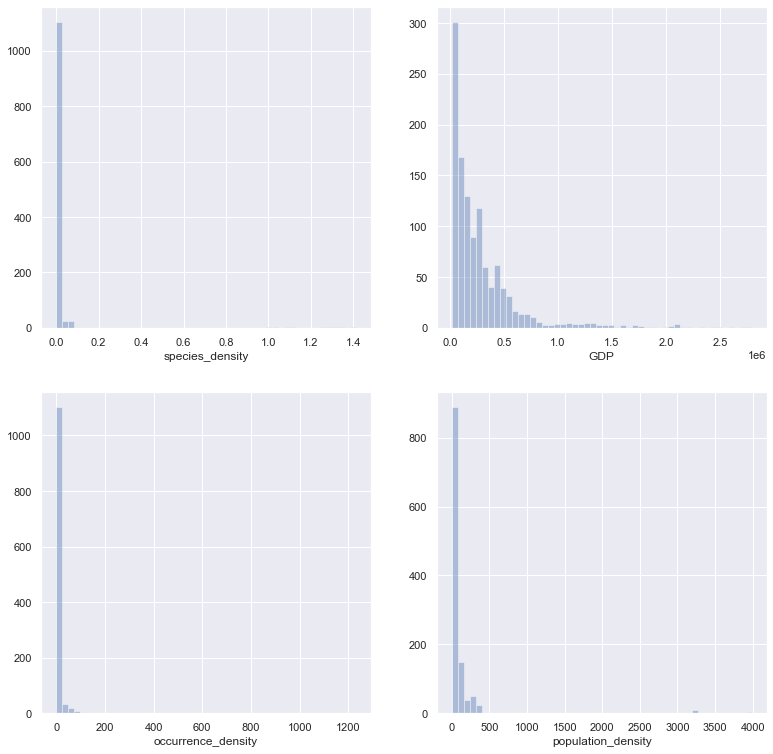

In [71]:
# This code generates an histogram
sns.set() 
f, axes = plt.subplots(2, 2, figsize=(13, 13))

ax1 = sns.distplot(eB_US_State_GDP_Pop1['species_density'],  kde = False, ax= axes [0,0])
ax2 = sns.distplot(eB_US_State_GDP_Pop1['occurrence_density'],  kde = False, ax= axes [1,0])
ax3 = sns.distplot(eB_US_State_GDP_Pop1['GDP'],  kde = False, ax= axes [0,1])
ax4 = sns.distplot(eB_US_State_GDP_Pop1['population_density'],  kde = False, ax= axes [1,1])

In [72]:
print(stats.describe(eB_US_State_GDP_Pop1['species_density']))
print(stats.describe(eB_US_State_GDP_Pop1['occurrence_density']))
print(stats.describe(eB_US_State_GDP_Pop1['GDP']))
print(stats.describe(eB_US_State_GDP_Pop1['population_density']))

DescribeResult(nobs=1173, minmax=(0.00017920094410171387, 1.4122092893036982), mean=0.028963165224825258, variance=0.0273027310875642, skewness=7.040881292497089, kurtosis=48.55491346007279)
DescribeResult(nobs=1173, minmax=(0.002435734282081857, 1231.5481793416548), mean=10.296522453880478, variance=3872.8234859256663, skewness=13.705431774480648, kurtosis=216.15555707031677)
DescribeResult(nobs=1173, minmax=(20026.1, 2792029.1), mean=300538.80707587383, variance=139596406094.7273, skewness=3.0889066414766, kurtosis=11.876322158144406)
DescribeResult(nobs=1173, minmax=(0.3530931327267058, 3986.6611748671826), mean=127.91294319870894, variance=225514.29814119675, skewness=6.759730551879477, kurtosis=45.36019979667508)


In [73]:
#GDP vs. Species Density(No. Spcs/ SQ Km)
pg.corr(x=eB_US_State_GDP_Pop1['GDP'], y=eB_US_State_GDP_Pop1['species_density'], method='spearman')

,n,r,CI95%,r2,adj_r2,p-val,power
spearman,1173,0.041977,"[-0.02, 0.1]",0.001762,0.000056,0.150781,0.300902


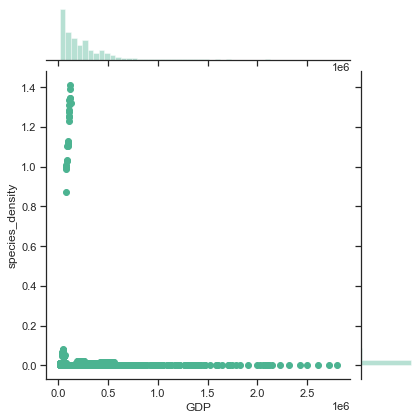

In [74]:
sns.set(style="ticks")
sns.jointplot(x=eB_US_State_GDP_Pop1['GDP'], y=eB_US_State_GDP_Pop1['species_density'],  color="#4CB391")

In [1]:
plt.scatter(x=eB_US_State_GDP_Pop1['GDP'], y=eB_US_State_GDP_Pop1['species_density'])
plt.show()

NameError: name 'plt' is not defined

In [107]:
#population_density (No. people/ SQ Km) vs Species Density(No. Spcs/ SQ Km)
pg.corr(x=eB_US_State_GDP_Pop1['population_density'], y=eB_US_State_GDP_Pop1['species_density'],  method='spearman')

,n,r,CI95%,r2,adj_r2,p-val,power
spearman,1173,0.714799,"[0.69, 0.74]",0.510938,0.510102,4.320186e-184,1.0


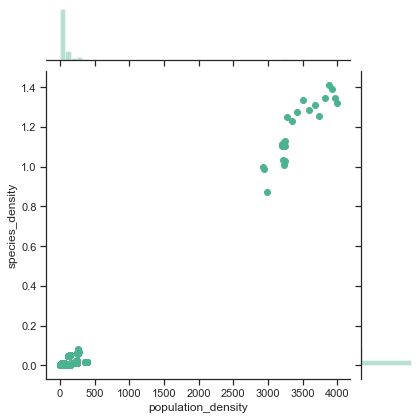

In [76]:
sns.set(style="ticks")
sns.jointplot(x=eB_US_State_GDP_Pop1['population_density'], y=eB_US_State_GDP_Pop1['species_density'],  color="#4CB391")

In [77]:
# GDP vs Occurrence Density(No. Occrr/ SQ Km)
pg.corr(x=eB_US_State_GDP_Pop1['GDP'], y=eB_US_State_GDP_Pop1['occurrence_density'], method='spearman')

,n,r,CI95%,r2,adj_r2,p-val,power
spearman,1173,0.397223,"[0.35, 0.44]",0.157786,0.156347,1.262781e-45,1.0


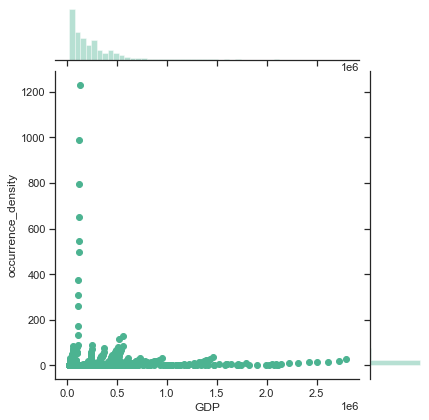

In [78]:
sns.set(style="ticks")
sns.jointplot(x=eB_US_State_GDP_Pop1['GDP'], y=eB_US_State_GDP_Pop1['occurrence_density'],  color="#4CB391")

In [2]:
# Population Density vs Occurrence Density(No. Occrr/ SQ Km)
pg.corr(x=eB_US_State_GDP_Pop1['population_density'], y=eB_US_State_GDP_Pop1['occurrence_density'], method='spearman')

NameError: name 'pg' is not defined

In [ ]:
#Kruskal_Wallis Test

In [111]:
eB_2001_ocurrenceD = x=eB_US_State_GDP_Pop1[eB_US_State_GDP_Pop1['year'] == 2001]['occurrence_density']
eB_2011_ocurrenceD = x=eB_US_State_GDP_Pop1[eB_US_State_GDP_Pop1['year'] == 2011]['occurrence_density']
eB_2019_ocurrenceD = x=eB_US_State_GDP_Pop1[eB_US_State_GDP_Pop1['year'] == 2019]['occurrence_density']

In [113]:
stat, p =stats.kruskal(eB_2001_ocurrenceD , eB_2011_ocurrenceD ,eB_2019_ocurrenceD )
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distributions (fail to reject H0)')
else:
    print('Different distributions (reject H0)')

Statistics=89.441, p=0.000
Different distributions (reject H0)


In [114]:
eB_2001_speciesD = x=eB_US_State_GDP_Pop1[eB_US_State_GDP_Pop1['year'] == 2001]['species_density']
eB_2011_speciesD = x=eB_US_State_GDP_Pop1[eB_US_State_GDP_Pop1['year'] == 2011]['species_density']
eB_2019_speciesD = x=eB_US_State_GDP_Pop1[eB_US_State_GDP_Pop1['year'] == 2019]['species_density']

In [115]:
stat, p =stats.kruskal(eB_2001_speciesD , eB_2011_speciesD ,eB_2019_speciesD )
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distributions (fail to reject H0)')
else:
    print('Different distributions (reject H0)')

Statistics=1.055, p=0.590
Same distributions (fail to reject H0)


In [117]:
eB_2001_GDP = x=eB_US_State_GDP_Pop1[eB_US_State_GDP_Pop1['year'] == 2001]['GDP']
eB_2011_GDP = x=eB_US_State_GDP_Pop1[eB_US_State_GDP_Pop1['year'] == 2011]['GDP']
eB_2019_GDP = x=eB_US_State_GDP_Pop1[eB_US_State_GDP_Pop1['year'] == 2019]['GDP']

In [118]:
stat, p =stats.kruskal(eB_2001_GDP , eB_2011_GDP ,eB_2019_GDP )
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distributions (fail to reject H0)')
else:
    print('Different distributions (reject H0)')

Statistics=2.196, p=0.334
Same distributions (fail to reject H0)


In [119]:
eB_2001_Population = x=eB_US_State_GDP_Pop1[eB_US_State_GDP_Pop1['year'] == 2001]['Population']
eB_2011_Population = x=eB_US_State_GDP_Pop1[eB_US_State_GDP_Pop1['year'] == 2011]['Population']
eB_2019_Population = x=eB_US_State_GDP_Pop1[eB_US_State_GDP_Pop1['year'] == 2019]['Population']

In [120]:
stat, p =stats.kruskal(eB_2001_Population , eB_2011_Population ,eB_2019_Population )
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distributions (fail to reject H0)')
else:
    print('Different distributions (reject H0)')

Statistics=0.699, p=0.705
Same distributions (fail to reject H0)


In [147]:
eB_US_State_GDP_Pop2 = eB_US_State_GDP_Pop1.groupby(['year'], as_index=False).occurrence_count.sum()

In [148]:
eB_US_State_GDP_Pop2

,year,occurrence_count
0,1997,1163128.0
1,1998,1318455.0
2,1999,1447983.0
3,2000,1625278.0
4,2001,1704063.0
5,2002,2071134.0
6,2003,2582663.0
7,2004,3035415.0
8,2005,3490245.0
9,2006,5031869.0


<Figure size 1440x1440 with 0 Axes>

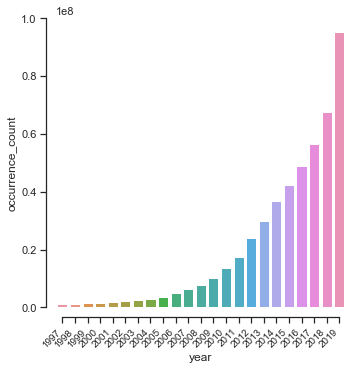

In [168]:
f = plt.figure(figsize=(20, 20))




g = sns.catplot(x='year', y= 'occurrence_count', kind="bar", data=eB_US_State_GDP_Pop2)

sns.despine(offset=10, trim=True);

plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='small'  
)

plt.show()


The null hypothesis of our experiment was:
Ho: There is no relationship between the average bird distribution in the U.S., the  GDP, and the population density.

We observed two different variables to test our null hypothesis, occurrence density and bird species density.
Occurrence density consisted of the instances in which a bird observation was recorded divided by the state's area in which the occurrence took place. Species density consisted of the count of unique bird species recorded on a specific state divided by the state's area.

From our analysis, we can conclude a significant difference between the observations made in the years 2001, 2011, and 2019. However, there is no considerable difference in the changes in GDP and population densities. Furthermore, a Spearman correlation test concluded no significant correlation between the occurrence density, GDP, and population density.

Regarding the species density variable, a Kruskal-Wallis test determined no significant difference in the species densities reported in the years 2001, 2011, and 2019. Similar to the results of the GDP distribution and Populations Density for the same years. A Spearman correlation test concluded a weak positive correlation between the species density and the GDP. A proven Correlation could explain this relationship between mean years of schooling and GDP per capita, 2010(https://ourworldindata.org/grapher/correlation-between-mean-years-of-schooling-and-gdp-per-capita). If higher GDP is related to more educated individuals, we are more likely to have more educated observers capable of identifying different bird species.

We need to keep in perspective that this database does not contain information on the universe of individuals who belong to a specific population; instead, what is recorded is when a particular species was observed.

We can conclude that for the occurrence density variable, we fail to reject our null hypothesis. We identify a weak correlation with the Gross Domestic Product by State but not for the Population Density for the species density variable.
